<a href="https://colab.research.google.com/github/Vasantha-Meghana/Predictive_Analytics_Projects/blob/Customer_Churn_Prediction/predictive3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

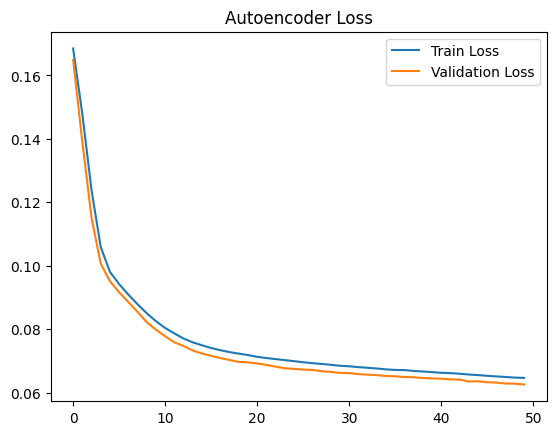

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reconstruction Error Threshold: 0.1075
[[1430   83]
 [ 654   27]]
              precision    recall  f1-score   support

 Not Churned       0.69      0.95      0.80      1513
     Churned       0.25      0.04      0.07       681

    accuracy                           0.66      2194
   macro avg       0.47      0.49      0.43      2194
weighted avg       0.55      0.66      0.57      2194



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('telecom_customer_churn.csv')

# Create binary churn label
df['Churn'] = df['Churn Category'].notnull().astype(int)

# Drop unnecessary columns
df.drop(['Customer Status', 'Churn Reason', 'Churn Category', 'Customer ID'], axis=1, errors='ignore', inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Convert 'Total Charges' to numeric if present
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop('Churn', axis=1))

# Prepare data
X = pd.DataFrame(scaled_data, columns=df.columns[:-1])
y = df['Churn'].values

# Use only non-churn customers for training (semi-supervised)
X_train = X[y == 0]
X_test = X

# Build autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=0
)

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Loss")
plt.show()

# Predict and calculate reconstruction error
X_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=1)

# Threshold for classification
threshold = np.percentile(mse, 95)
print(f"Reconstruction Error Threshold: {threshold:.4f}")

# Predict churn based on anomaly
y_pred = (mse > threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=['Not Churned', 'Churned']))